In [152]:
import pandas as pd
import numpy as np
import seaborn as sns
import operator
from matplotlib import pyplot as plt

In [153]:
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
random_state = 42

In [154]:
df = pd.read_csv('data/application_train.csv')
df.head()

SK_ID_CURR  TARGET NAME_CONTRACT_TYPE CODE_GENDER FLAG_OWN_CAR  \
0      100002       1         Cash loans           M            N   
1      100003       0         Cash loans           F            N   
2      100004       0    Revolving loans           M            Y   
3      100006       0         Cash loans           F            N   
4      100007       0         Cash loans           M            N   

  FLAG_OWN_REALTY  CNT_CHILDREN  AMT_INCOME_TOTAL  AMT_CREDIT  AMT_ANNUITY  \
0               Y             0          202500.0    406597.5      24700.5   
1               N             0          270000.0   1293502.5      35698.5   
2               Y             0           67500.0    135000.0       6750.0   
3               Y             0          135000.0    312682.5      29686.5   
4               Y             0          121500.0    513000.0      21865.5   

   AMT_GOODS_PRICE NAME_TYPE_SUITE NAME_INCOME_TYPE  \
0         351000.0   Unaccompanied          Working   
1        1129500.0          Family    State servant   
2         135000.0   Unaccompanied          Working   
3         297000.0   Unaccompanied          Working   
4         513000.0   Unaccompanied          Working   

             NAME_EDUCATION_TYPE    NAME_FAMILY_STATUS  NAME_HOUSING_TYPE  \
0  Secondary / secondary special  Single / not married  House / apartment   
1               Higher education               Married  House / apartment   
2  Secondary / secondary special  Single / not married  House / apartment   
3  Secondary / secondary special        Civil marriage  House / apartment   
4  Secondary / secondary special  Single / not married  House / apartment   

   REGION_POPULATION_RELATIVE  DAYS_BIRTH  DAYS_EMPLOYED  DAYS_REGISTRATION  \
0                    0.018801       -9461           -637            -3648.0   
1                    0.003541      -16765          -1188            -1186.0   
2                    0.010032      -19046           -225            -4260.0   
3                    0.008019      -19005          -3039            -9833.0   
4                    0.028663      -19932          -3038            -4311.0   

   DAYS_ID_PUBLISH  OWN_CAR_AGE  FLAG_MOBIL  FLAG_EMP_PHONE  FLAG_WORK_PHONE  \
0            -2120          NaN           1               1                0   
1             -291          NaN           1               1                0   
2            -2531         26.0           1               1                1   
3            -2437          NaN           1               1                0   
4            -3458          NaN           1               1                0   

   FLAG_CONT_MOBILE  FLAG_PHONE  FLAG_EMAIL OCCUPATION_TYPE  CNT_FAM_MEMBERS  \
0                 1           1           0        Laborers              1.0   
1                 1           1           0      Core staff              2.0   
2                 1           1           0        Laborers              1.0   
3                 1           0           0        Laborers              2.0   
4                 1           0           0      Core staff              1.0   

   REGION_RATING_CLIENT  REGION_RATING_CLIENT_W_CITY  \
0                     2                            2   
1                     1                            1   
2                     2                            2   
3                     2                            2   
4                     2                            2   

  WEEKDAY_APPR_PROCESS_START  HOUR_APPR_PROCESS_START  \
0                  WEDNESDAY                       10   
1                     MONDAY                       11   
2                     MONDAY                        9   
3                  WEDNESDAY                       17   
4                   THURSDAY                       11   

   REG_REGION_NOT_LIVE_REGION  REG_REGION_NOT_WORK_REGION  \
0                           0                           0   
1                           0                           0   
2                        

In [155]:
# 10 самых значимых признаков из логистической регрессииы

most_val_features = ['DAYS_EMPLOYED',
                     'ORGANIZATION_TYPE',
                     'AMT_GOODS_PRICE',
                     'AMT_CREDIT',
                     'EXT_SOURCE_3',
                     'FLAG_EMP_PHONE',
                     'NAME_INCOME_TYPE',
                     'EXT_SOURCE_2']

In [156]:
sns.set(
    style="white", 
    palette="muted", 
    color_codes=True,
    rc={'figure.figsize':(12,8)}
)

In [157]:
sns.pairplot(
    df[most_val_features + ['TARGET']].sample(15000),
    hue='TARGET'
);

In [158]:
sns.heatmap(
    df[most_val_features + ['TARGET']].corr(),
    annot=True
);

In [159]:
# DAYS_EMPLOYED
df['DAYS_EMPLOYED'].describe()

count    307511.000000
mean      63815.045904
std      141275.766519
min      -17912.000000
25%       -2760.000000
50%       -1213.000000
75%        -289.000000
max      365243.000000
Name: DAYS_EMPLOYED, dtype: float64

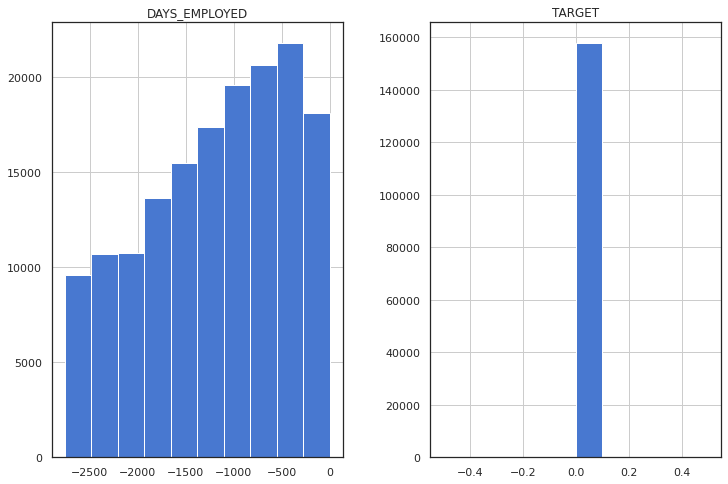

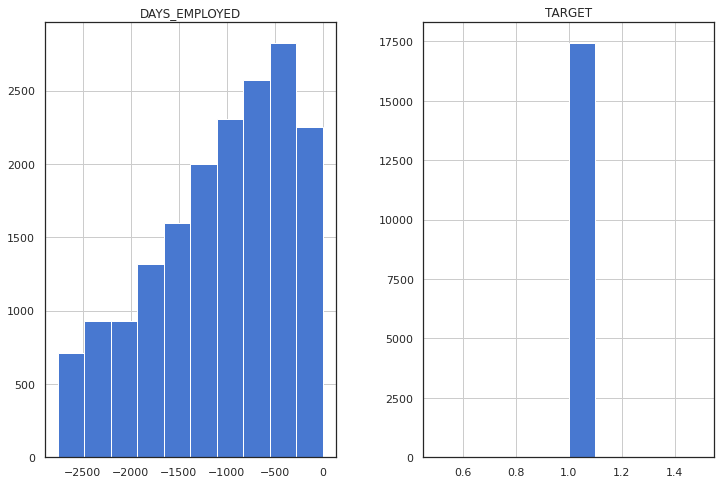

In [160]:
df[(df['DAYS_EMPLOYED'] <= 0) & (df['DAYS_EMPLOYED'] >= -2760)]\
  [['DAYS_EMPLOYED', 'TARGET']].groupby('TARGET')\
                               .hist();

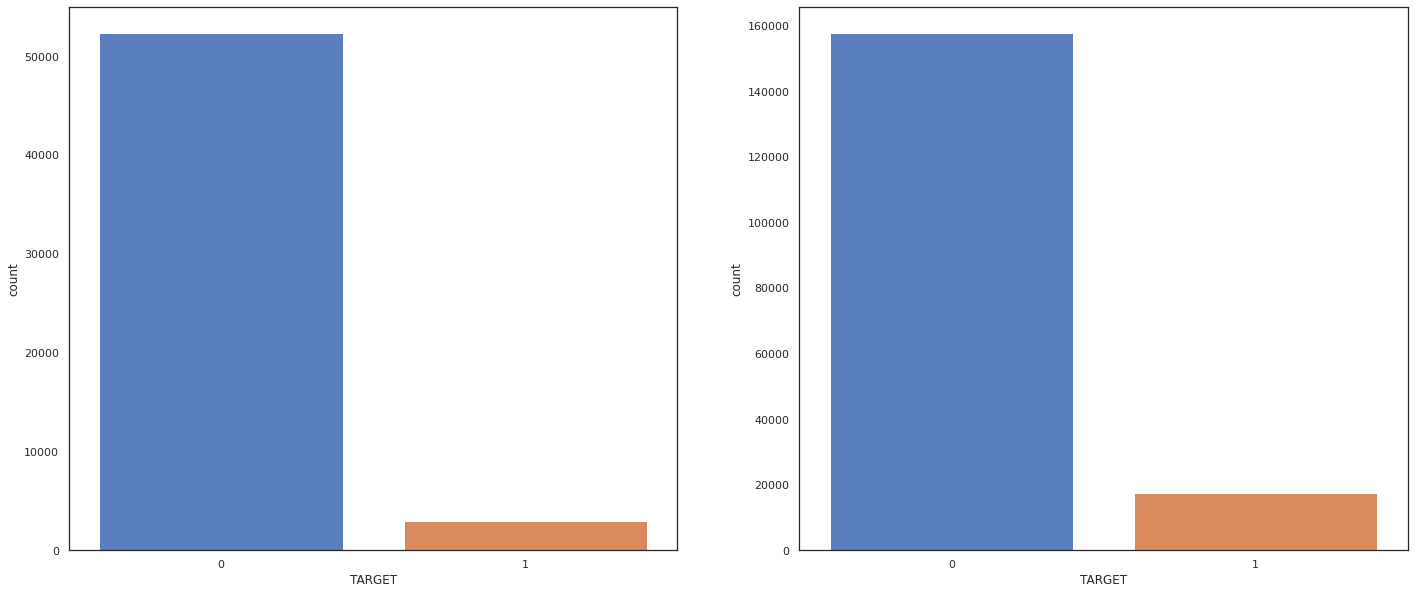

In [161]:
fig, ax = plt.subplots(1, 2, figsize=(24, 10))
sns.countplot(x=df[df['DAYS_EMPLOYED'] > 0]['TARGET'], ax=ax[0])
sns.countplot(x=df[(df['DAYS_EMPLOYED'] <= 0) & (df['DAYS_EMPLOYED'] >= -2760)]
                  ['TARGET'], ax=ax[1])
plt.show();

In [175]:
sns.catplot(x='TARGET', y='DAYS_EMPLOYED', kind='box', 
            data=df[df['DAYS_EMPLOYED'] <= 0], height=8, aspect=1.2);

In [162]:
df[df['DAYS_EMPLOYED'] > 0]['TARGET'].mean(), \
df[(df['DAYS_EMPLOYED'] <= 0) & (df['DAYS_EMPLOYED'] >= -2760)]['TARGET'].mean(), \
df[df['DAYS_EMPLOYED'] < 0]['TARGET'].mean()

(0.05399646043269404, 0.09944940518643197, 0.08659646617883276)

In [177]:
# Скорее всего стоит удалить данные выбросы (то, что больше 0)
# Они все имеют одно значение, однакосреди них есть как 0 так и 1
df[df['DAYS_EMPLOYED'] > 0]['TARGET'].shape

(55374,)

In [163]:
# ORGANIZATION_TYPE
df['ORGANIZATION_TYPE'].describe()

count                     307511
unique                        58
top       Business Entity Type 3
freq                       67992
Name: ORGANIZATION_TYPE, dtype: object

In [164]:
df['ORGANIZATION_TYPE'] = df['ORGANIZATION_TYPE'] \
                            .apply(lambda x: x[:x.find(':')] if x.find(':') > 0
                                                             else x)

In [165]:
df['ORGANIZATION_TYPE'] = df['ORGANIZATION_TYPE'] \
                            .apply(lambda x: x[:x.find(' Type')] 
                                             if x.find(' Type') > 0
                                             else x)

In [166]:
main_orgs = df['ORGANIZATION_TYPE'].value_counts()[:14]

In [167]:
df['ORGANIZATION_TYPE'] = df['ORGANIZATION_TYPE'] \
                            .apply(lambda x: x if x in main_orgs else 'Other')

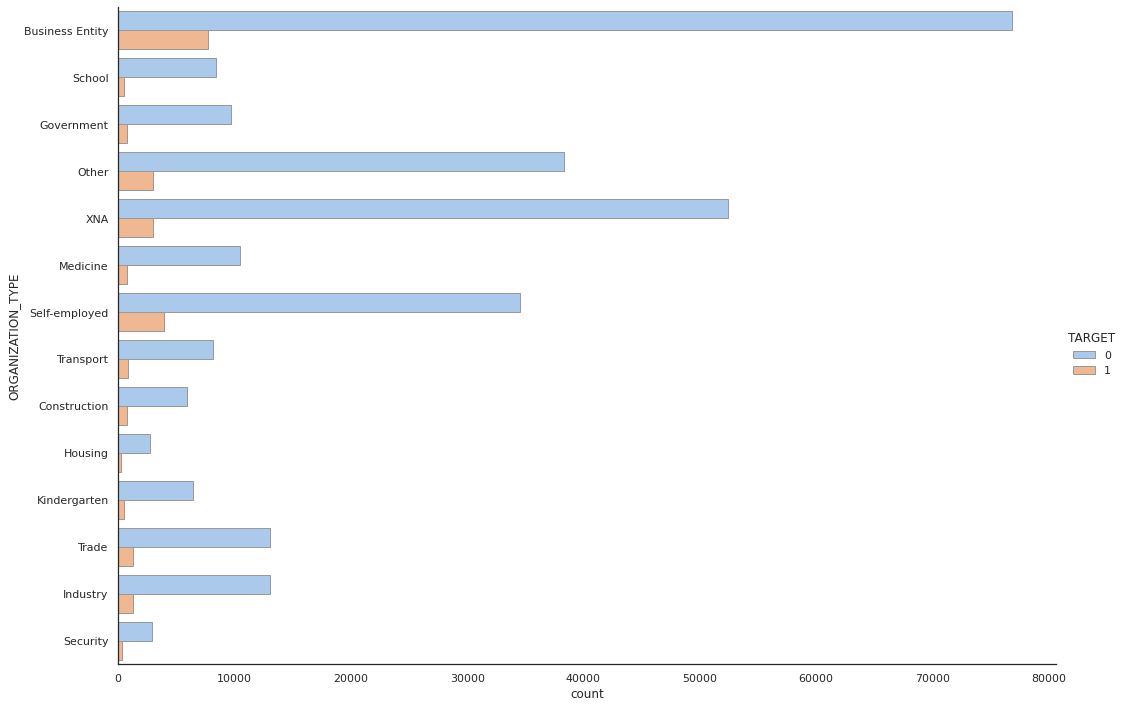

In [170]:
sns.catplot(y='ORGANIZATION_TYPE', hue='TARGET', kind="count",
            palette="pastel", edgecolor=".6",
            data=df, height=10, aspect=1.5);

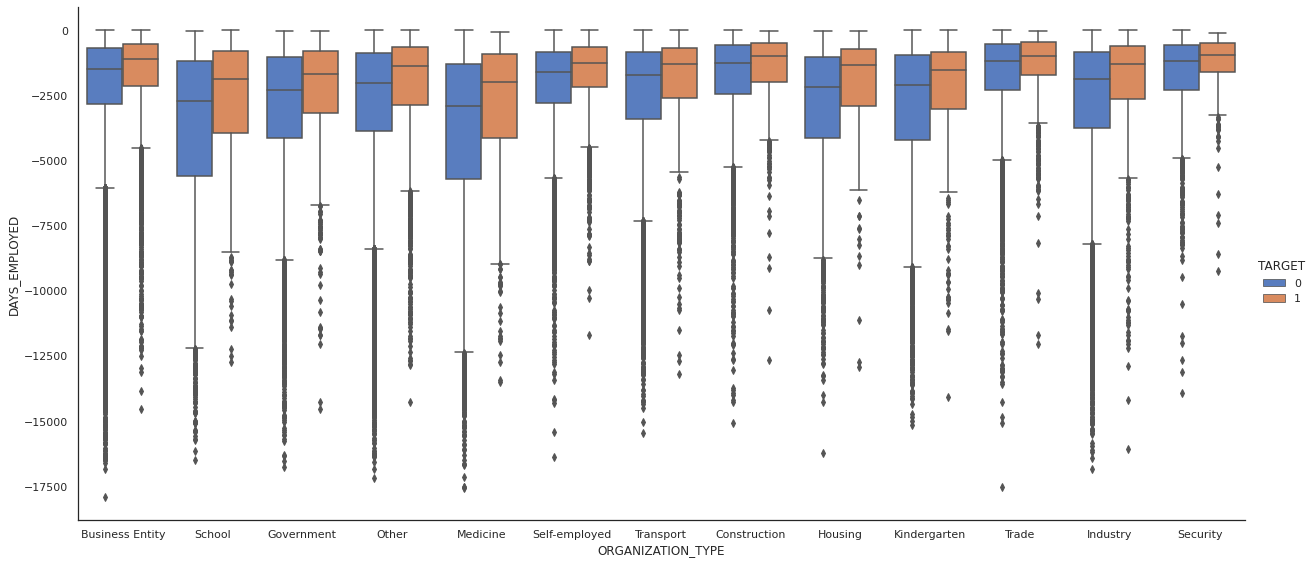

In [180]:
sns.catplot(x='ORGANIZATION_TYPE', y='DAYS_EMPLOYED', hue='TARGET', kind='box', 
            data=df[df['DAYS_EMPLOYED'] <= 0], height=8, aspect=2.2);

In [189]:
df[(df['DAYS_EMPLOYED'] <= 0) & (df['ORGANIZATION_TYPE'] == 'XNA')].shape,\
df[df['DAYS_EMPLOYED'] > 0].shape,

((0, 122), (55374, 122))

In [ ]:
# Все выбросы в DAYS_EMPLOYED имеют тип организации XNA
# Не понятно, что за XNA, далее попытаемся это выяснить

In [191]:
df[df['ORGANIZATION_TYPE'] == 'XNA'].describe(include=['object'])

NAME_CONTRACT_TYPE CODE_GENDER FLAG_OWN_CAR FLAG_OWN_REALTY  \
count               55374       55374        55374           55374   
unique                  2           2            2               2   
top            Cash loans           F            N               Y   
freq                52008       45271        45205           42230   

       NAME_TYPE_SUITE NAME_INCOME_TYPE            NAME_EDUCATION_TYPE  \
count            55178            55374                          55374   
unique               7                2                              5   
top      Unaccompanied        Pensioner  Secondary / secondary special   
freq             43508            55352                          45105   

       NAME_FAMILY_STATUS  NAME_HOUSING_TYPE OCCUPATION_TYPE  \
count               55374              55374               2   
unique                  5                  6               1   
top               Married  House / apartment  Cleaning staff   
freq                32518              52385               2   

       WEEKDAY_APPR_PROCESS_START ORGANIZATION_TYPE FONDKAPREMONT_MODE  \
count                       55374             55374              17161   
unique                          7                 1                  4   
top                       TUESDAY               XNA   reg oper account   
freq                         9953             55374              13093   

        HOUSETYPE_MODE WALLSMATERIAL_MODE EMERGENCYSTATE_MODE  
count            26929              26640               28469  
unique               3                  7                   2  
top     block of flats              Panel                  No  
freq             26562              11701               28087

In [192]:
df.describe(include=['object'])

NAME_CONTRACT_TYPE CODE_GENDER FLAG_OWN_CAR FLAG_OWN_REALTY  \
count              307511      307511       307511          307511   
unique                  2           3            2               2   
top            Cash loans           F            N               Y   
freq               278232      202448       202924          213312   

       NAME_TYPE_SUITE NAME_INCOME_TYPE            NAME_EDUCATION_TYPE  \
count           306219           307511                         307511   
unique               7                8                              5   
top      Unaccompanied          Working  Secondary / secondary special   
freq            248526           158774                         218391   

       NAME_FAMILY_STATUS  NAME_HOUSING_TYPE OCCUPATION_TYPE  \
count              307511             307511          211120   
unique                  6                  6              18   
top               Married  House / apartment        Laborers   
freq               196432             272868           55186   

       WEEKDAY_APPR_PROCESS_START ORGANIZATION_TYPE FONDKAPREMONT_MODE  \
count                      307511            307511              97216   
unique                          7                14                  4   
top                       TUESDAY   Business Entity   reg oper account   
freq                        53901             84529              73830   

        HOUSETYPE_MODE WALLSMATERIAL_MODE EMERGENCYSTATE_MODE  
count           153214             151170              161756  
unique               3                  7                   2  
top     block of flats              Panel                  No  
freq            150503              66040              159428

In [195]:
df[df['ORGANIZATION_TYPE'] == 'XNA']['CODE_GENDER'].unique(), \
df['CODE_GENDER'].unique()

(array(['F', 'M'], dtype=object), array(['M', 'F', 'XNA'], dtype=object))

In [ ]:
# XNA проставляется, если информация отсутствует

In [200]:
df[df['ORGANIZATION_TYPE'] == 'XNA']['OCCUPATION_TYPE'].isna().mean(), \
df['OCCUPATION_TYPE'].isna().mean()
# Почти везде, где XNA -- пропуски

(0.9999638819662657, 0.31345545362604915)

In [201]:
df[df['ORGANIZATION_TYPE'] == 'XNA'].describe()

SK_ID_CURR        TARGET  CNT_CHILDREN  AMT_INCOME_TOTAL  \
count   55374.000000  55374.000000  55374.000000      5.537400e+04   
mean   278480.472424      0.053996      0.046123      1.363956e+05   
std    102674.560705      0.226013      0.275873      7.666086e+04   
min    100011.000000      0.000000      0.000000      2.565000e+04   
25%    189622.250000      0.000000      0.000000      9.000000e+04   
50%    279001.500000      0.000000      0.000000      1.170000e+05   
75%    367053.000000      0.000000      0.000000      1.665000e+05   
max    456252.000000      1.000000     14.000000      2.250000e+06   

         AMT_CREDIT    AMT_ANNUITY  AMT_GOODS_PRICE  \
count  5.537400e+04   55374.000000     5.535200e+04   
mean   5.426899e+05   23904.303202     4.882973e+05   
std    3.784991e+05   13308.379238     3.471510e+05   
min    4.500000e+04    1615.500000     4.500000e+04   
25%    2.547000e+05   14503.500000     2.250000e+05   
50%    4.578345e+05   21775.500000     4.500000e+05   
75%    7.551900e+05   29943.000000     6.750000e+05   
max    3.312162e+06  225000.000000     3.150000e+06   

       REGION_POPULATION_RELATIVE    DAYS_BIRTH  DAYS_EMPLOYED  \
count                55374.000000  55374.000000        55374.0   
mean                     0.020749 -21810.009373       365243.0   
std                      0.013635   2008.084123            0.0   
min                      0.000290 -25229.000000       365243.0   
25%                      0.010032 -23173.000000       365243.0   
50%                      0.018850 -22051.000000       365243.0   
75%                      0.026392 -20839.000000       365243.0   
max                      0.072508  -7691.000000       365243.0   

       DAYS_REGISTRATION  DAYS_ID_PUBLISH   OWN_CAR_AGE  FLAG_MOBIL  \
count       55374.000000     55374.000000  10169.000000     55374.0   
mean        -6582.930978     -3875.560155     13.090766         1.0   
std          4201.502789      1117.887551     11.544117         0.0   
min        -24672.000000     -6337.000000      0.000000         1.0   
25%         -9976.000000     -4572.000000      6.000000         1.0   
50%         -6304.000000     -4201.000000     11.000000         1.0   
75%         -2932.250000     -3602.000000     17.000000         1.0   
max             0.000000         0.000000     65.000000         1.0   

       FLAG_EMP_PHONE  FLAG_WORK_PHONE  FLAG_CONT_MOBILE    FLAG_PHONE  \
count         55374.0     55374.000000      55374.000000  55374.000000   
mean              0.0         0.000018          0.999314      0.296475   
std               0.0         0.004250          0.026187      0.456707   
min               0.0         0.000000          0.000000      0.000000   
25%               0.0         0.000000          1.000000      0.000000   
50%               0.0         0.000000          1.000000      0.000000   
75%               0.0         0.000000          1.000000      1.000000   
max               0.0         1.000000          1.000000      1.000000   

         FLAG_EMAIL  CNT_FAM_MEMBERS  REGION_RATING_CLIENT  \
count  55374.000000     55374.000000          55374.000000   
mean       0.025842         1.697981              2.088200   
std        0.158667         0.558580              0.491916   
min        0.000000         1.000000              1.000000   
25%        0.000000         1.000000              2.000000   
50%        0.000000         2.000000              2.000000   
75%        0.000000         2.000000              2.000000   
max        1.000000        16.000000              3.000000   

       REGION_RATING_CLIENT_W_CITY  HOUR_APPR_PROCESS_START  \
count                 55374.000000             55374.000000   
mean                      2.068805                11.426482   
std                       0.483858                 3.025820   
min                       1.000000                 0.000000   
25%                       2.000000                 9.000000   
50%                       2.000000          

In [202]:
df.describe()

SK_ID_CURR         TARGET   CNT_CHILDREN  AMT_INCOME_TOTAL  \
count  307511.000000  307511.000000  307511.000000      3.075110e+05   
mean   278180.518577       0.080729       0.417052      1.687979e+05   
std    102790.175348       0.272419       0.722121      2.371231e+05   
min    100002.000000       0.000000       0.000000      2.565000e+04   
25%    189145.500000       0.000000       0.000000      1.125000e+05   
50%    278202.000000       0.000000       0.000000      1.471500e+05   
75%    367142.500000       0.000000       1.000000      2.025000e+05   
max    456255.000000       1.000000      19.000000      1.170000e+08   

         AMT_CREDIT    AMT_ANNUITY  AMT_GOODS_PRICE  \
count  3.075110e+05  307499.000000     3.072330e+05   
mean   5.990260e+05   27108.573909     5.383962e+05   
std    4.024908e+05   14493.737315     3.694465e+05   
min    4.500000e+04    1615.500000     4.050000e+04   
25%    2.700000e+05   16524.000000     2.385000e+05   
50%    5.135310e+05   24903.000000     4.500000e+05   
75%    8.086500e+05   34596.000000     6.795000e+05   
max    4.050000e+06  258025.500000     4.050000e+06   

       REGION_POPULATION_RELATIVE     DAYS_BIRTH  DAYS_EMPLOYED  \
count               307511.000000  307511.000000  307511.000000   
mean                     0.020868  -16036.995067   63815.045904   
std                      0.013831    4363.988632  141275.766519   
min                      0.000290  -25229.000000  -17912.000000   
25%                      0.010006  -19682.000000   -2760.000000   
50%                      0.018850  -15750.000000   -1213.000000   
75%                      0.028663  -12413.000000    -289.000000   
max                      0.072508   -7489.000000  365243.000000   

       DAYS_REGISTRATION  DAYS_ID_PUBLISH    OWN_CAR_AGE     FLAG_MOBIL  \
count      307511.000000    307511.000000  104582.000000  307511.000000   
mean        -4986.120328     -2994.202373      12.061091       0.999997   
std          3522.886321      1509.450419      11.944812       0.001803   
min        -24672.000000     -7197.000000       0.000000       0.000000   
25%         -7479.500000     -4299.000000       5.000000       1.000000   
50%         -4504.000000     -3254.000000       9.000000       1.000000   
75%         -2010.000000     -1720.000000      15.000000       1.000000   
max             0.000000         0.000000      91.000000       1.000000   

       FLAG_EMP_PHONE  FLAG_WORK_PHONE  FLAG_CONT_MOBILE     FLAG_PHONE  \
count   307511.000000    307511.000000     307511.000000  307511.000000   
mean         0.819889         0.199368          0.998133       0.281066   
std          0.384280         0.399526          0.043164       0.449521   
min          0.000000         0.000000          0.000000       0.000000   
25%          1.000000         0.000000          1.000000       0.000000   
50%          1.000000         0.000000          1.000000       0.000000   
75%          1.000000         0.000000          1.000000       1.000000   
max          1.000000         1.000000          1.000000       1.000000   

          FLAG_EMAIL  CNT_FAM_MEMBERS  REGION_RATING_CLIENT  \
count  307511.000000    307509.000000         307511.000000   
mean        0.056720         2.152665              2.052463   
std         0.231307         0.910682              0.509034   
min         0.000000         1.000000              1.000000   
25%         0.000000         2.000000              2.000000   
50%         0.000000         2.000000              2.000000   
75%         0.000000         3.000000              2.000000   
max         1.000000        20.000000              3.000000   

       REGION_RATING_CLIENT_W_CITY  HOUR_APPR_PROCESS_START  \
count                307511.000000            307511.000000   
mean                      2.031521                12.063419   
std                       0.502737                 3.265832   
min                       1.000000                 0.000000   
25%                       

In [270]:
df[df.columns[df.dtypes == 'float']].nunique().values[56:]

array([  33,    9, 3773,    5,    9,    9,   24,   11,   25])

In [271]:
df[df['ORGANIZATION_TYPE'] == 'XNA'] \
  [df.columns[df.dtypes == 'float']].nunique().values[56:]

array([  27,    8, 3388,    4,    8,    7,   18,    8,   22])

In [272]:
df.columns[df.dtypes == 'float'][56:]

Index(['OBS_60_CNT_SOCIAL_CIRCLE', 'DEF_60_CNT_SOCIAL_CIRCLE',
       'DAYS_LAST_PHONE_CHANGE', 'AMT_REQ_CREDIT_BUREAU_HOUR',
       'AMT_REQ_CREDIT_BUREAU_DAY', 'AMT_REQ_CREDIT_BUREAU_WEEK',
       'AMT_REQ_CREDIT_BUREAU_MON', 'AMT_REQ_CREDIT_BUREAU_QRT',
       'AMT_REQ_CREDIT_BUREAU_YEAR'],
      dtype='object')

In [230]:
df['FLAG_DOCUMENT_2'].unique(), \
df[df['ORGANIZATION_TYPE'] == 'XNA']['FLAG_DOCUMENT_2'].unique(), \
df[df['ORGANIZATION_TYPE'] != 'XNA']['FLAG_DOCUMENT_2'].unique()

(array([0, 1]), array([0]), array([0, 1]))

In [ ]:
# Подобным анализом не выявлено ничего странного в данных типа int и float
# Далее будет протестировано удаление всех строк, где organization type = XNA